In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
from func import *
#%run /home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/func.ipynb
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/CMIP6_func.ipynb
#from CMIP6_func import *
%matplotlib inline

In [2]:
client = Client(n_workers=5)
client

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44935 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44935/status,
Dashboard: http://127.0.0.1:44935/status,Workers: 5
Total threads: 20,Total memory: 62.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32811,Workers: 5
Dashboard: http://127.0.0.1:44935/status,Total threads: 20
Started: Just now,Total memory: 62.81 GiB
Comm: tcp://127.0.0.1:32865,Total threads: 4
Dashboard: http://127.0.0.1:41029/status,Memory: 12.56 GiB
Nanny: tcp://127.0.0.1:43357,


# Open CMIP6 online catalog & download desired data

In [ ]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'])
cam = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])
waccm.df
cam.df

/srv/conda/envs/notebook/lib/python3.9/site-packages/intake_esm/search.py:106: UserWarning: Query returned zero results.
  warn(message)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


2022-11-14 15:18:23,970 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-14 15:18:23,971 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-14 15:18:23,971 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-14 15:18:24,020 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,023 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,053 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,062 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,119 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,205 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,209 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,232 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,261 - distributed.nanny - WARNING - Restarting worker
2022-11-14 15:18:24,270 - distributed.nanny - WARNING - Restarting worker

In [4]:
ds_dict_waccm = waccm.to_dataset_dict(zarr_kwargs={'use_cftime':True}, cdf_kwargs={"chunks": {"time": 40}})
ds_dict_cam = cam.to_dataset_dict(zarr_kwargs={'use_cftime':True},cdf_kwargs={"chunks": {"time": 4}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
print(list(ds_dict_waccm.keys()))
print(list(ds_dict_cam.keys()))
waccm = ds_dict_waccm['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
cam = ds_dict_cam['CMIP.NCAR.CESM2.historical.Amon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
['CMIP.NCAR.CESM2.historical.Amon.gn']


# Rechunk the dataset to optimize dask

In [10]:
# Each worker should have en even number of workload. 
# For this dataset I have time:1980 divided by 5 gives me an even number of 396.
# I should therefore have 5 workers when using dask.
# This will also wotk if I decide to calculate the yearly mean. 
# I have 165 years. 5 workers will then each have 33 years to work on simultaneously 

# This dataset is already chunked as wished, no need to change

# If change is needed:
#waccm.chunk(time=33).chunks
#waccm.o3[0]

# Krakatoa eruption in 1883

In [ ]:
# Select the starting year 5 years prior to the eruption
start_krak = cftime.DatetimeNoLeap(1878,1,15)
end_krak = cftime.DatetimeNoLeap(1888,1,15)

# WACCM
waccm_1877_1887 = waccm.sel(time=slice(start_krak, end_krak))
# CAM
cam_1877_1887 = cam.sel(time=slice(start_krak, end_krak))

# Creates a new variable called totO3 for WACCM and CAM 
waccm_1877_1887_o3 = calculate_total_ozone_p(waccm_1877_1887).totO3
cam_1877_1887_o3 = calculate_total_ozone_p(cam_1877_1887).totO3

In [8]:
cam

<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, member_id: 3, time: 1980, plev: 19)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    o3         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 30, 19, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    frequency:               mon
    initialization_index:    1
    intake_esm_varname:      ['o3']
    sub_experiment_id:       none
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    tracking_id:             hdl:21.14100/bced181b-ce48-4fc1-abf9-0085195d789...
    ...                      ...
    realm:                   atmos atmosChem
    creation_date:           2019-01-18T18:19:46Z
    branch_method:           standard
    branch_time_in_parent:   240900.0
    sub_experiment:          none
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

## Calculate the anomaly

In [20]:
# Yearly
year_waccm_anom_1877_1887_o3 = calc_yearly_anomaly(waccm_1877_1887_o3,1883)
year_cam_anom_1877_1887_o3 = calc_yearly_anomaly(cam_1877_1887_o3,1883)

# Monthly 
mon_waccm_anom_1877_1887_o3 = calc_monthly_anomaly(waccm_1877_1887_o3,1883)
mon_cam_anom_1877_1887_o3 = calc_monthly_anomaly(cam_1877_1887_o3,1883)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


## Calculate the weight for the northern and southern hemispheres

In [9]:
# Yearly
# WACCM
year_waccm_NH_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where(year_waccm_anom_1877_1887_o3['lat']>60.)).compute()
year_waccm_SH_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where(year_waccm_anom_1877_1887_o3['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where(year_cam_anom_1877_1887_o3['lat']>60.)).compute()
year_cam_SH_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where(year_cam_anom_1877_1887_o3['lat']<-60.)).compute()

In [10]:
# Monthly
# WACCM
mon_waccm_NH_anom_krak_o3 = computeWeightedMean(mon_waccm_anom_1877_1887_o3.where(mon_waccm_anom_1877_1887_o3['lat']>60.)).compute()
mon_waccm_SH_anom_krak_o3 = computeWeightedMean(mon_waccm_anom_1877_1887_o3.where(mon_waccm_anom_1877_1887_o3['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_krak_o3 = computeWeightedMean(mon_cam_anom_1877_1887_o3.where(mon_cam_anom_1877_1887_o3['lat']>60.)).compute()
mon_cam_SH_anom_krak_o3 = computeWeightedMean(mon_cam_anom_1877_1887_o3.where(mon_cam_anom_1877_1887_o3['lat']<-60.)).compute()

In [44]:
waccm_krak = xr.open_dataset('WACCM_1877_1887_o3.nc')
cam_krak = xr.open_dataset('CAM_1877_1887_o3.nc')

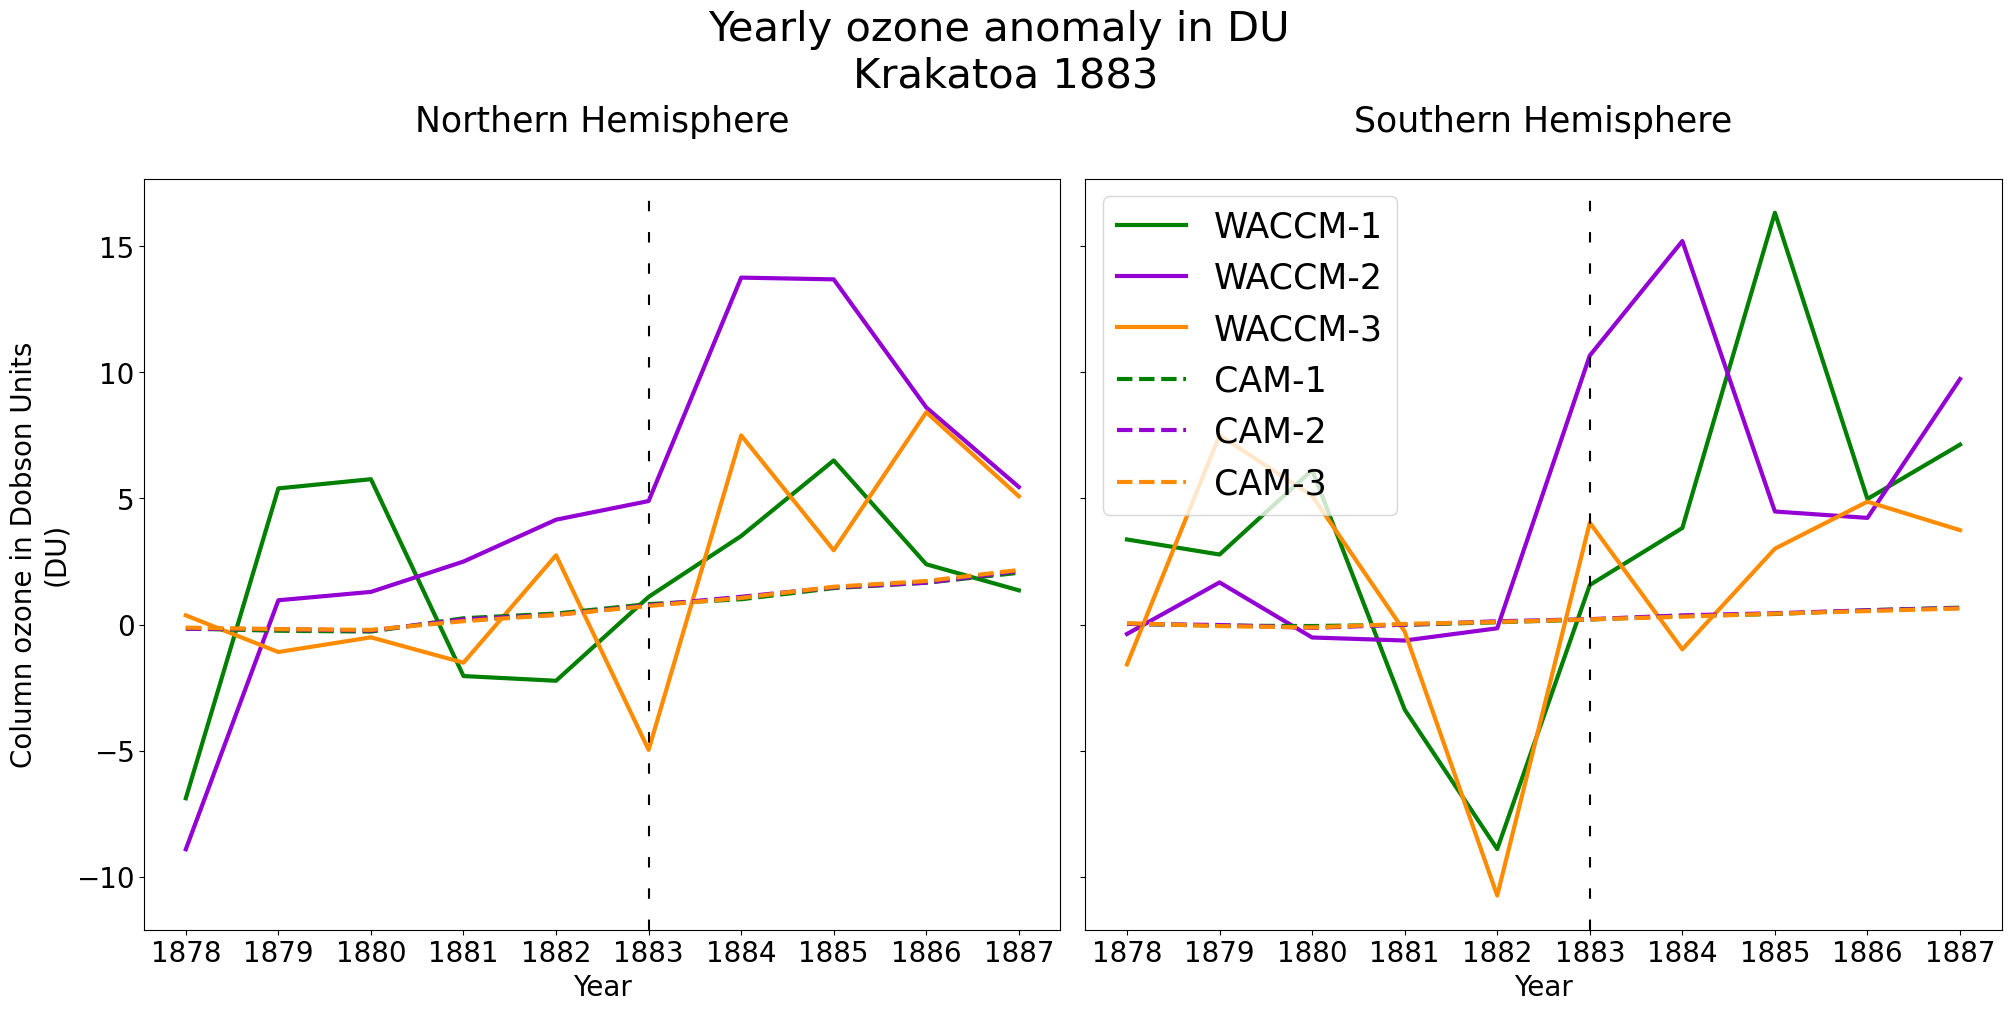

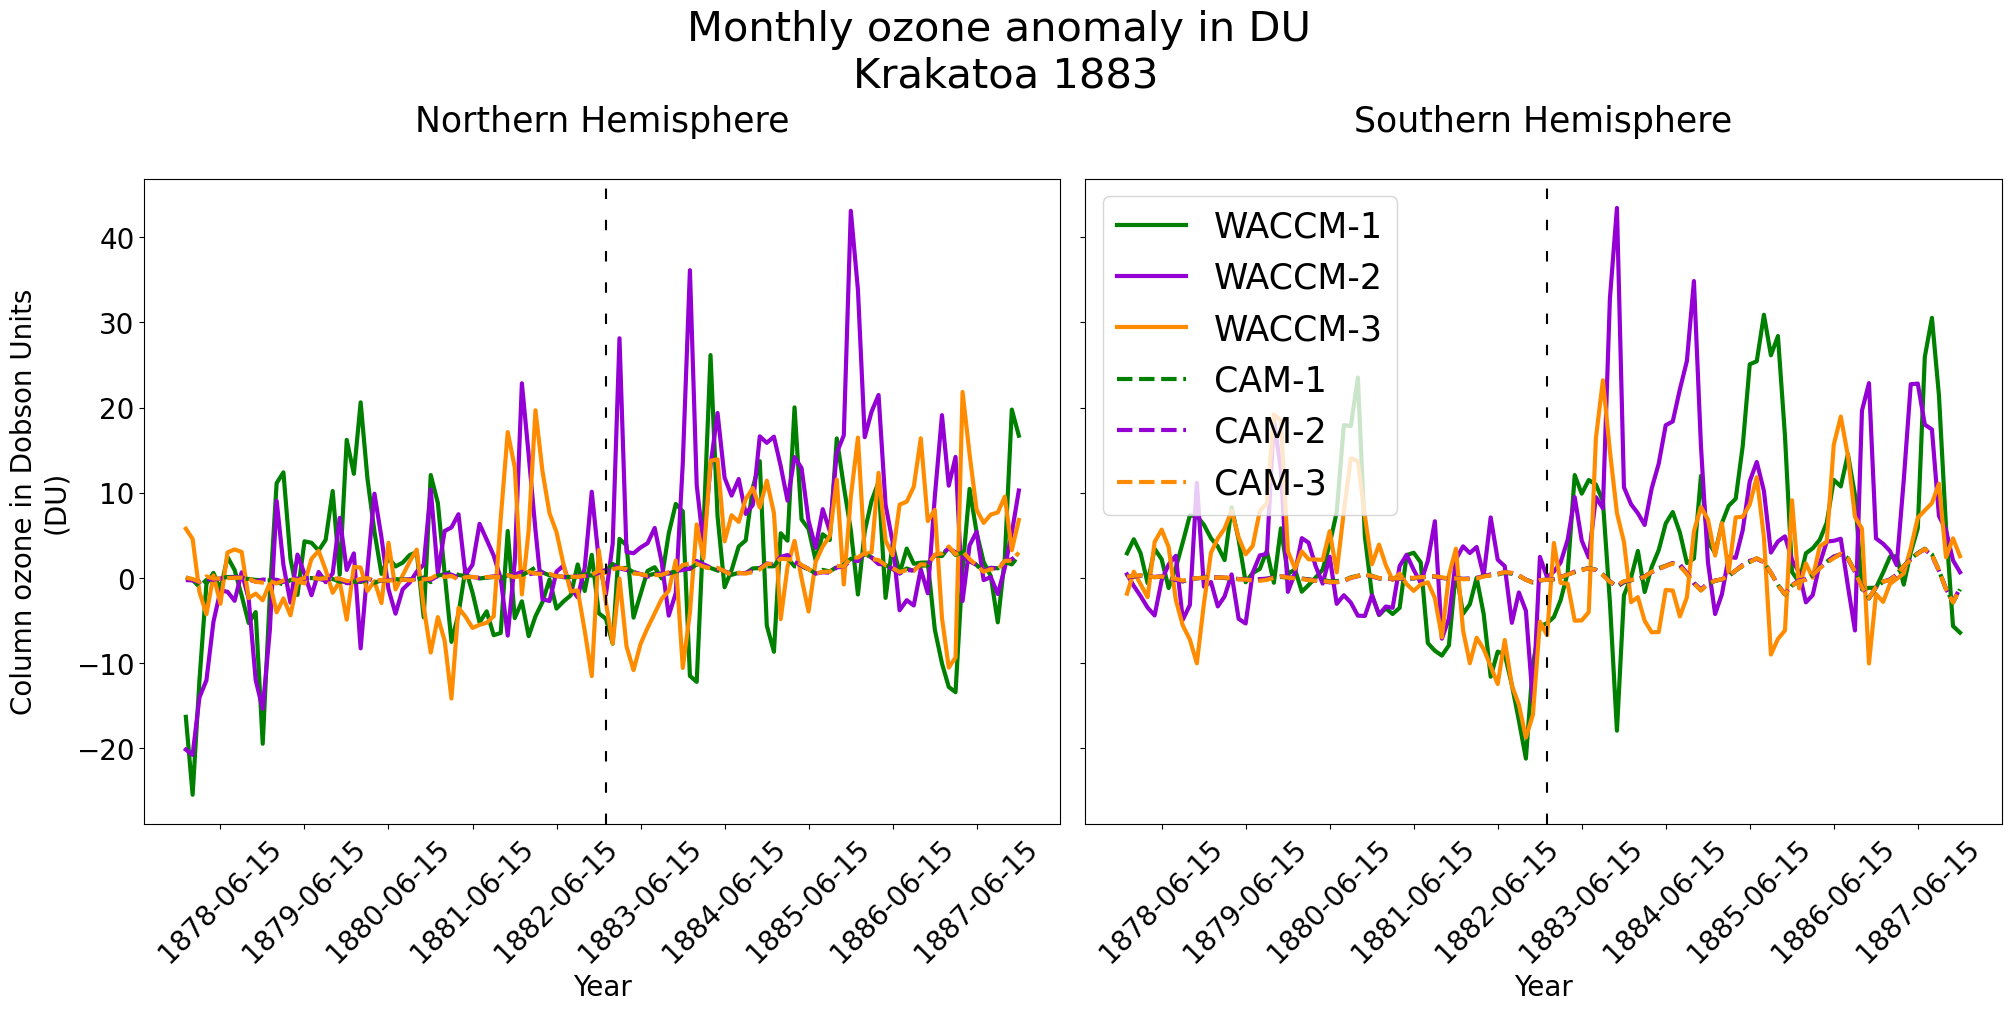

In [6]:
path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'
#plot_year(year_waccm_NH_anom_krak_o3, year_waccm_SH_anom_krak_o3, year_cam_NH_anom_krak_o3,year_cam_SH_anom_krak_o3,'Yearly ozone anomaly in DU \nKrakatoa 1883')
plot_year(waccm_krak.year_NH_anom,waccm_krak.year_SH_anom,cam_krak.year_NH_anom,cam_krak.year_SH_anom,'Yearly ozone anomaly in DU \nKrakatoa 1883')
#plt.savefig(path + 'O3_yearly_krak.png')
#plot_start_krak = cftime.DatetimeNoLeap(1883,1,15)
#plot_end_krak = cftime.DatetimeNoLeap(1887,1,15)
plot_month(waccm_krak.mon_NH_anom,waccm_krak.mon_SH_anom,cam_krak.mon_NH_anom,cam_krak.mon_SH_anom,'Monthly ozone anomaly in DU \nKrakatoa 1883')
#plt.savefig(path + 'O3_monthly_krak.png')
#plot_month(mon_waccm_NH_anom_krak_o3, mon_waccm_SH_anom_krak_o3, mon_cam_NH_anom_krak_o3,mon_cam_SH_anom_krak_o3,'Monthly ozone anomaly in DU \nKrakatoa 1883')
#plot_month(mon_waccm_NH_anom_krak_o3.sel(time=slice(plot_start_krak, plot_end_krak)), mon_waccm_SH_anom_krak_o3.sel(time=slice(plot_start_krak, plot_end_krak)), mon_cam_NH_anom_krak_o3.sel(time=slice(plot_start_krak, plot_end_krak)),mon_cam_SH_anom_krak_o3.sel(time=slice(plot_start_krak, plot_end_krak)),'Monthly ozone anomaly in DU \nKrakatoa 1883')

## Calculate the weight for the -60 < lat > 60 region

In [28]:
# Yearly
# WACCM
year_waccm_trop_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where((year_waccm_anom_1877_1887_o3['lat']<60.) & (year_waccm_anom_1877_1887_o3['lat']>-60.))).compute()
#year_waccm_SH_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where(year_waccm_anom_1877_1887_o3['lat']<-60.)).compute()

# CAM
year_cam_trop_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where((year_cam_anom_1877_1887_o3['lat']<60.) & (year_cam_anom_1877_1887_o3['lat']>-60.))).compute()
#year_cam_SH_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where(year_cam_anom_1877_1887_o3['lat']<-60.)).compute()

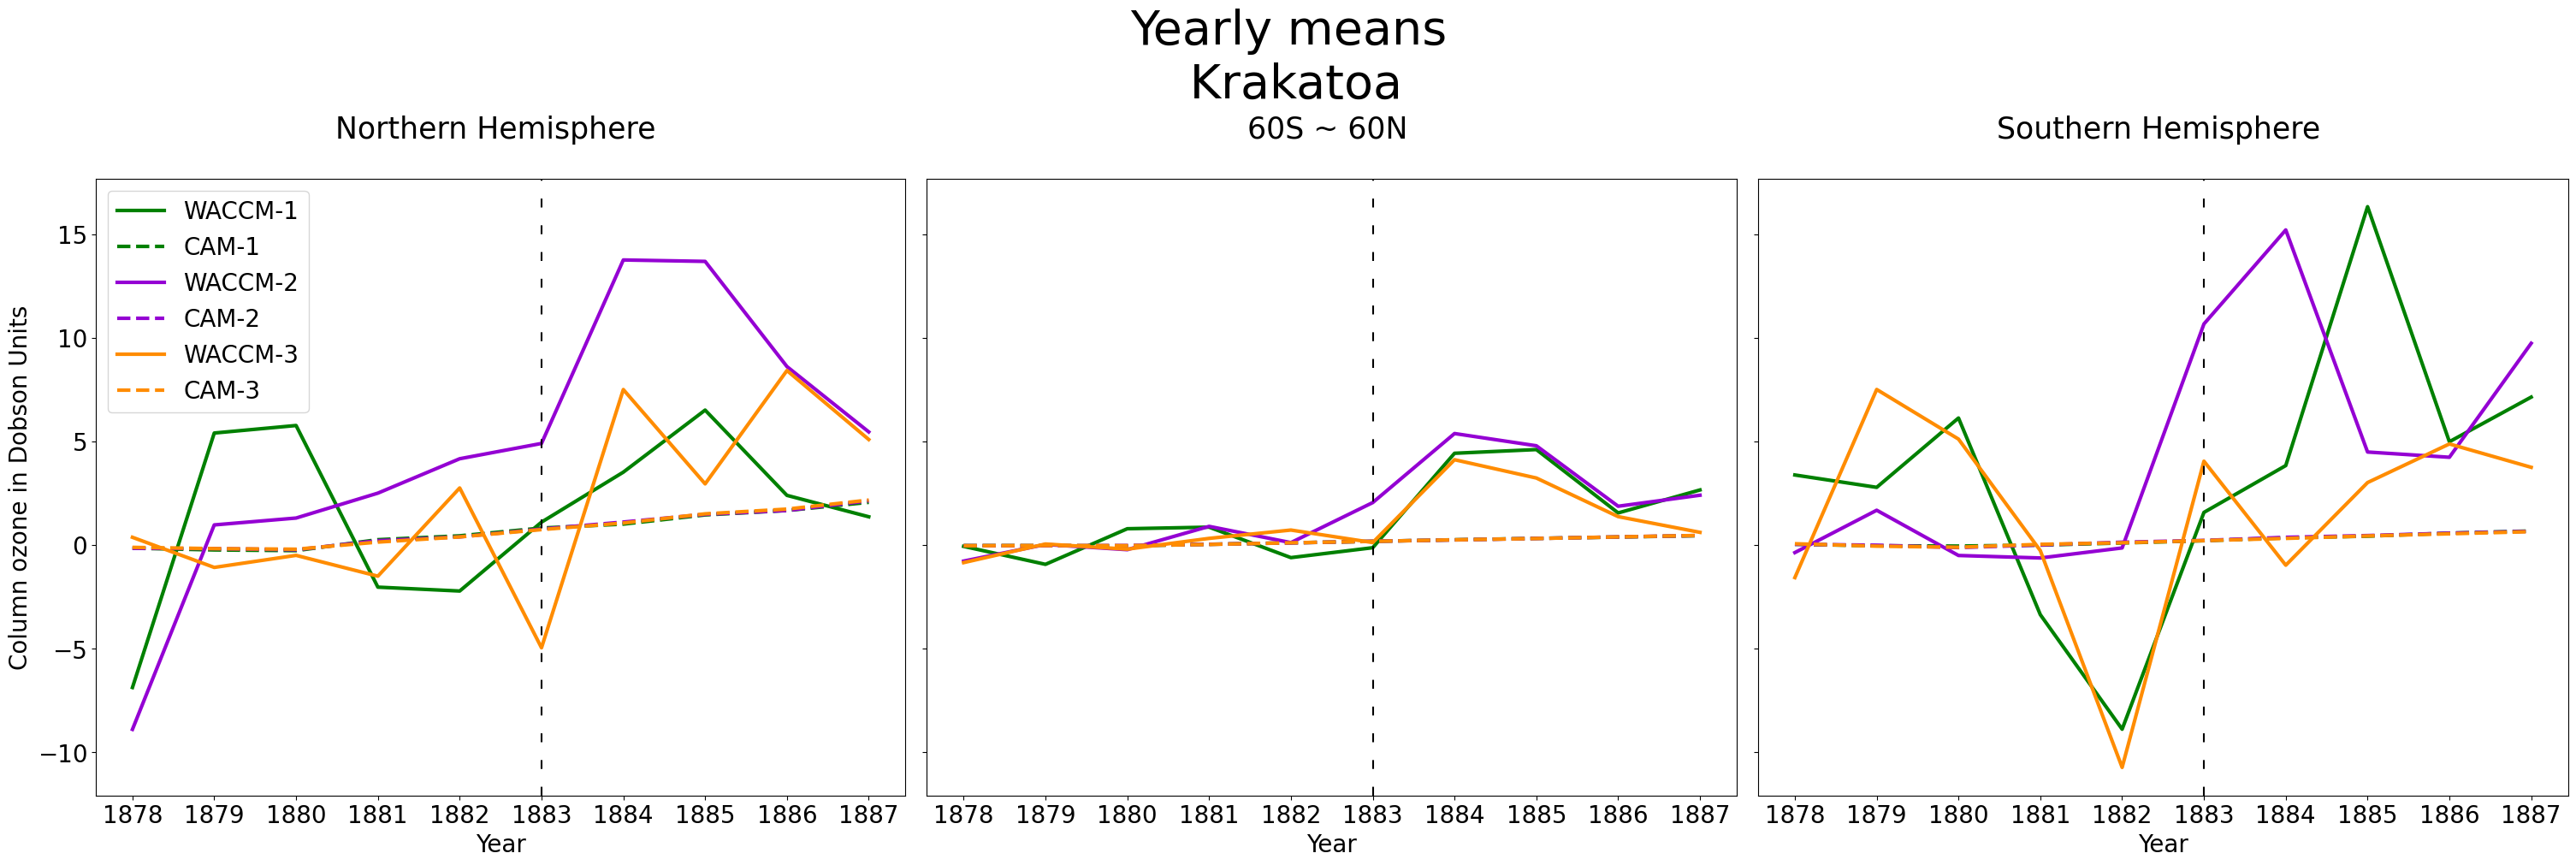

In [40]:
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, constrained_layout=True, sharey=True, figsize=(30,10))


color = ['green','darkviolet','darkorange']

for i in range(3):
    j = i+1
    waccm_krak.year_NH_anom[i].plot(label='WACCM-'+ str(j), ax=axs1, linewidth=3, color=color[i])
    cam_krak.year_NH_anom[i].plot(label='CAM-'+ str(j), ax=axs1, linestyle='--', linewidth=3, color=color[i])

for i in range(3):
    j = i+1
    year_waccm_trop_anom_krak_o3[i].plot(label='WACCM-'+ str(j), ax=axs2, linewidth=3, color=color[i])
    year_cam_trop_anom_krak_o3[i].plot(label='CAM-'+ str(j), ax=axs2, linestyle='--', linewidth=3, color=color[i])
    
for i in range(3):
    j = i+1
    waccm_krak.year_SH_anom[i].plot(label='WACCM-'+ str(j), ax=axs3, linewidth=3, color=color[i])
    cam_krak.year_SH_anom[i].plot(label="CAM-"+ str(j), ax=axs3, linestyle='--', linewidth=3, color=color[i])

axs1.axvline(1883, color='k',linestyle='--',dashes=(5, 10))
axs2.axvline(1883, color='k',linestyle='--',dashes=(5, 10))
axs3.axvline(1883, color='k',linestyle='--',dashes=(5, 10))

fig.suptitle('Yearly means\n Krakatoa', fontsize=40)

axs1.set_xticks(cam_krak.year_SH_anom.year)
axs2.set_xticks(cam_krak.year_SH_anom.year)
axs3.set_xticks(cam_krak.year_SH_anom.year)

axs1.set_ylabel(year_waccm_trop_anom_krak_o3.long_name, fontsize=20)
axs2.set_ylabel('', fontsize=20)
axs3.set_ylabel('', fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)
axs3.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)
axs3.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)
axs3.tick_params(axis="y", labelsize=20)

axs1.set_title("Northern Hemisphere \n" , fontsize=25)
axs2.set_title("60S ~ 60N \n" , fontsize=25)
axs3.set_title("Southern Hemisphere \n" , fontsize=25)

axs1.legend(fontsize=20)
path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'
plt.savefig(path + 'AOD_yearly.png')



# Mount Pinatubo eruption in 1991

In [8]:
# Select the starting year 5 years prior to the eruption
start_pina = cftime.DatetimeNoLeap(1986,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
waccm_1986_1996 = waccm.sel(time=slice(start_pina, end_pina))
# CAM
cam_1986_1996 = cam.sel(time=slice(start_pina, end_pina))

# Creates a new variable called totO3 for WACCM and CAM 
waccm_1986_1996_o3 = calculate_total_ozone_p(waccm_1986_1996).totO3
cam_1986_1996_o3 = calculate_total_ozone_p(cam_1986_1996).totO3

Minimum column ozone value: 58.61533162268342
Minimum column ozone value: 123.06848968692877


## Calculate the anomaly

In [9]:
# Yearly
year_waccm_anom_1986_1996_o3 = calc_yearly_anomaly(waccm_1986_1996_o3,1991)
year_cam_anom_1986_1996_o3 = calc_yearly_anomaly(cam_1986_1996_o3,1991)

# Monthly
mon_waccm_anom_1986_1996_o3 = calc_monthly_anomaly(waccm_1986_1996_o3,1991)
mon_cam_anom_1986_1996_o3 = calc_monthly_anomaly(cam_1986_1996_o3,1991)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


## Calculate the weight for the northern and southern hemispheres

In [ ]:
# Yearly
# WACCM
year_waccm_NH_anom_pina_o3 = computeWeightedMean(year_waccm_anom_1986_1996_o3.where(year_waccm_anom_1986_1996_o3['lat']>60.)).compute()
year_waccm_SH_anom_pina_o3 = computeWeightedMean(year_waccm_anom_1986_1996_o3.where(year_waccm_anom_1986_1996_o3['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_pina_o3 = computeWeightedMean(year_cam_anom_1986_1996_o3.where(year_cam_anom_1986_1996_o3['lat']>60.)).compute()
year_cam_SH_anom_pina_o3 = computeWeightedMean(year_cam_anom_1986_1996_o3.where(year_cam_anom_1986_1996_o3['lat']<-60.)).compute()

In [33]:
# Monthly
# WACCM
mon_waccm_NH_anom_pina_o3 = computeWeightedMean(mon_waccm_anom_1986_1996_o3.where(mon_waccm_anom_1986_1996_o3['lat']>60.)).compute()
mon_waccm_SH_anom_pina_o3 = computeWeightedMean(mon_waccm_anom_1986_1996_o3.where(mon_waccm_anom_1986_1996_o3['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_pina_o3 = computeWeightedMean(mon_cam_anom_1986_1996_o3.where(mon_cam_anom_1986_1996_o3['lat']>60.)).compute()
mon_cam_SH_anom_pina_o3 = computeWeightedMean(mon_cam_anom_1986_1996_o3.where(mon_cam_anom_1986_1996_o3['lat']<-60.)).compute()

In [10]:
waccm_pina = xr.open_dataset('WACCM_1986_1996_o3.nc')
cam_pina = xr.open_dataset('CAM_1986_1996_o3.nc')

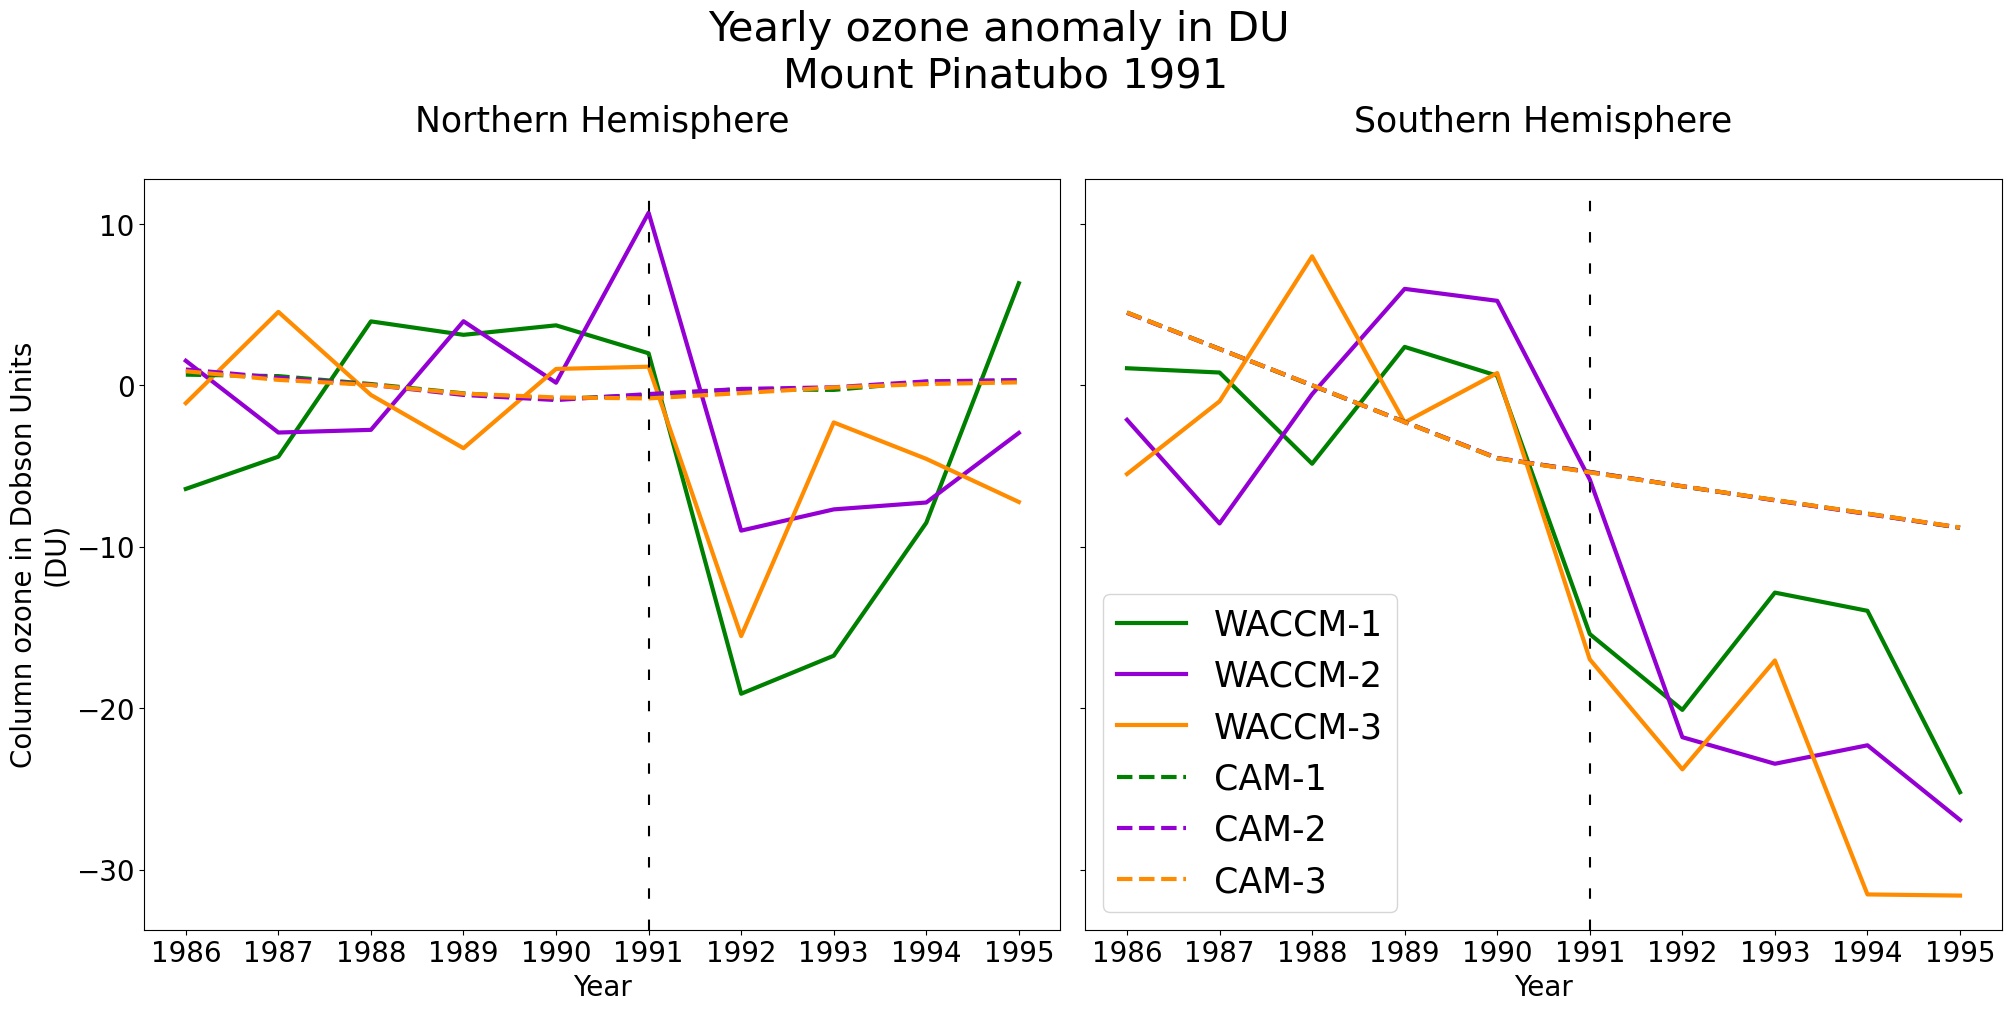

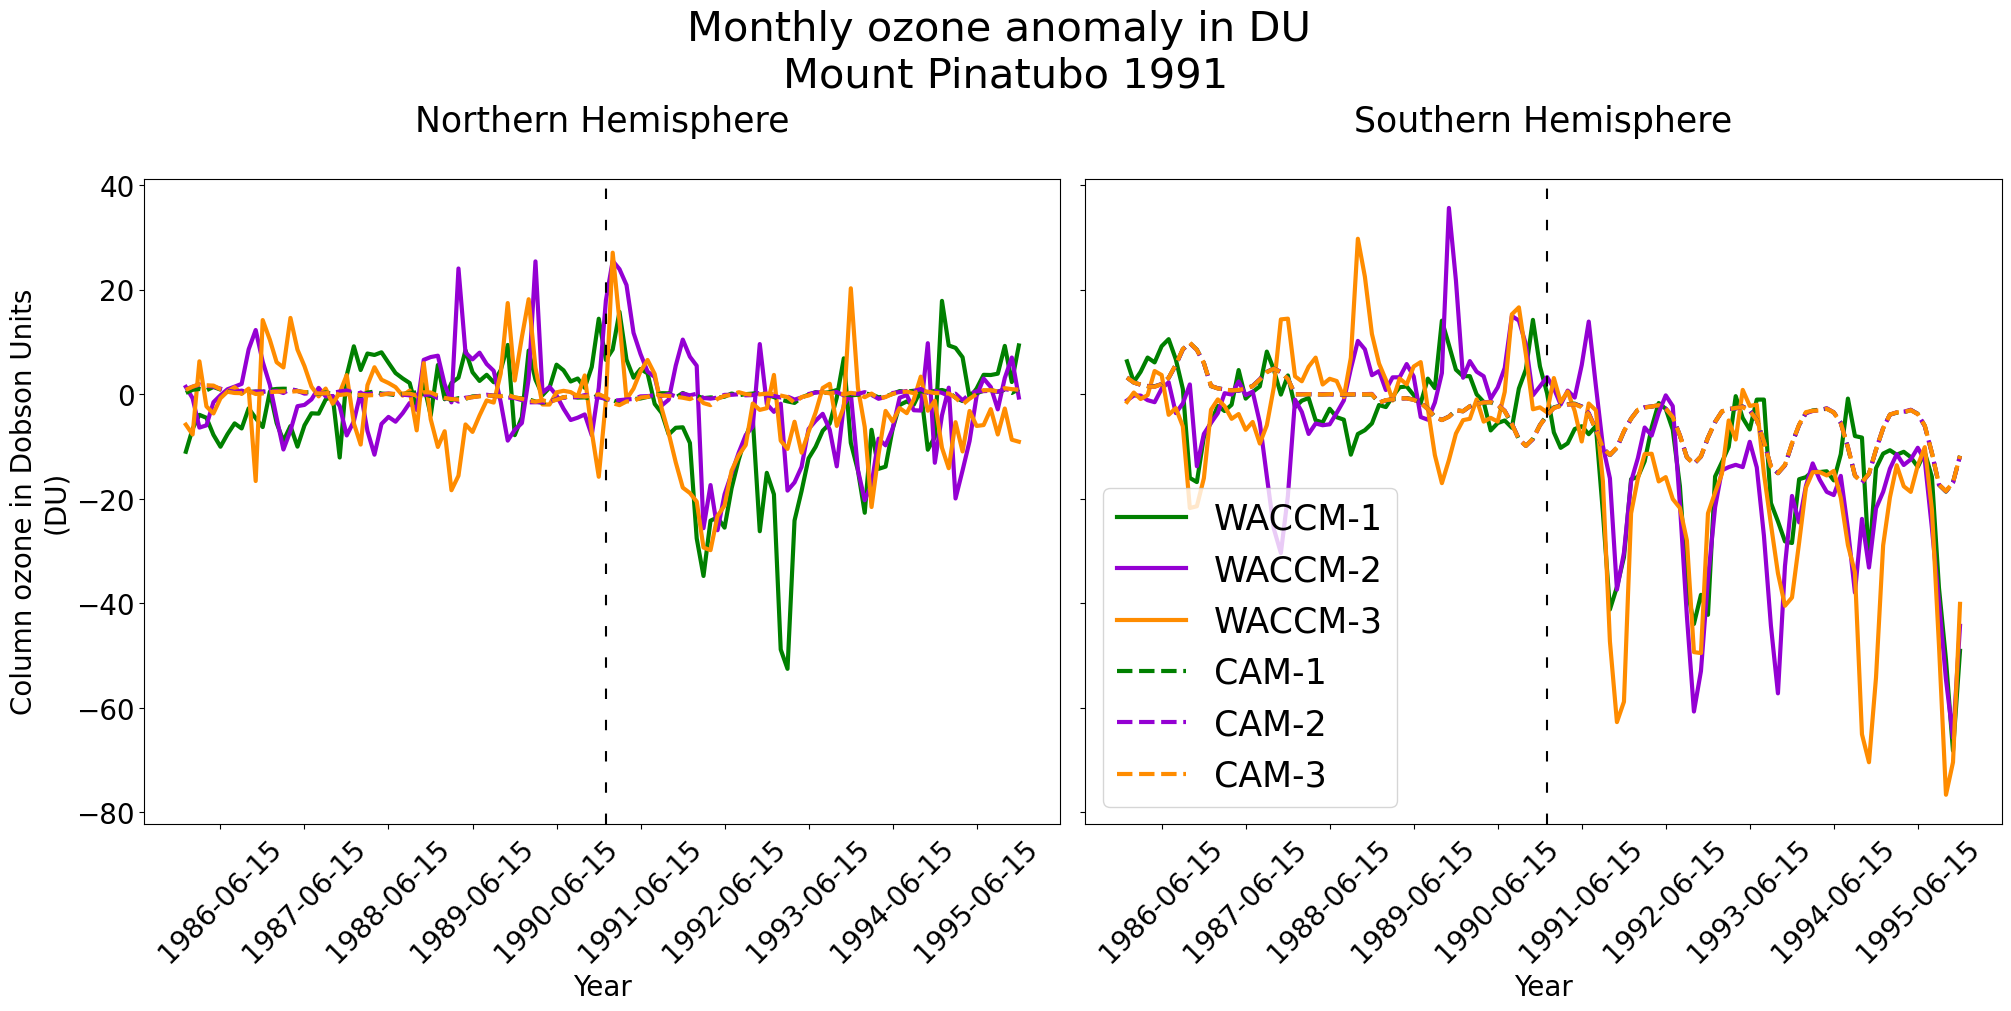

In [29]:
#plot_year(year_waccm_NH_anom_pina_o3,year_waccm_SH_anom_pina_o3,year_cam_NH_anom_pina_o3,year_cam_NH_anom_pina_o3,'Yearly ozone anomaly in DU \nMount Pinatubo')
plot_year(waccm_pina.year_NH_anom,waccm_pina.year_SH_anom,cam_pina.year_NH_anom,cam_pina.year_SH_anom,'Yearly ozone anomaly in DU \nMount Pinatubo 1991')
#plt.savefig(path + 'O3_yearly_pina.png')

#plot_month(mon_waccm_NH_anom_pina_o3,mon_waccm_SH_anom_pina_o3,mon_cam_NH_anom_pina_o3,mon_cam_NH_anom_pina_o3,'Monthly ozone anomaly in DU \nMount Pinatubo')
plot_month(waccm_pina.mon_NH_anom,waccm_pina.mon_SH_anom,cam_pina.mon_NH_anom,cam_pina.mon_SH_anom,'Monthly ozone anomaly in DU \nMount Pinatubo 1991')
#plt.savefig(path + 'O3_montly_pina.png')

## Calculate the weight for the -60 < lat > 60 region

In [30]:
# Yearly
# WACCM
year_waccm_trop_anom_pina_o3 = computeWeightedMean(year_waccm_anom_1986_1996_o3.where((year_waccm_anom_1986_1996_o3['lat']<60.) & (year_waccm_anom_1986_1996_o3['lat']>-60.))).compute()
#year_waccm_SH_anom_krak_o3 = computeWeightedMean(year_waccm_anom_1877_1887_o3.where(year_waccm_anom_1877_1887_o3['lat']<-60.)).compute()

# CAM
year_cam_trop_anom_pina_o3 = computeWeightedMean(year_cam_anom_1986_1996_o3.where((year_cam_anom_1986_1996_o3['lat']<60.) & (year_cam_anom_1986_1996_o3['lat']>-60.))).compute()
#year_cam_SH_anom_krak_o3 = computeWeightedMean(year_cam_anom_1877_1887_o3.where(year_cam_anom_1877_1887_o3['lat']<-60.)).compute()

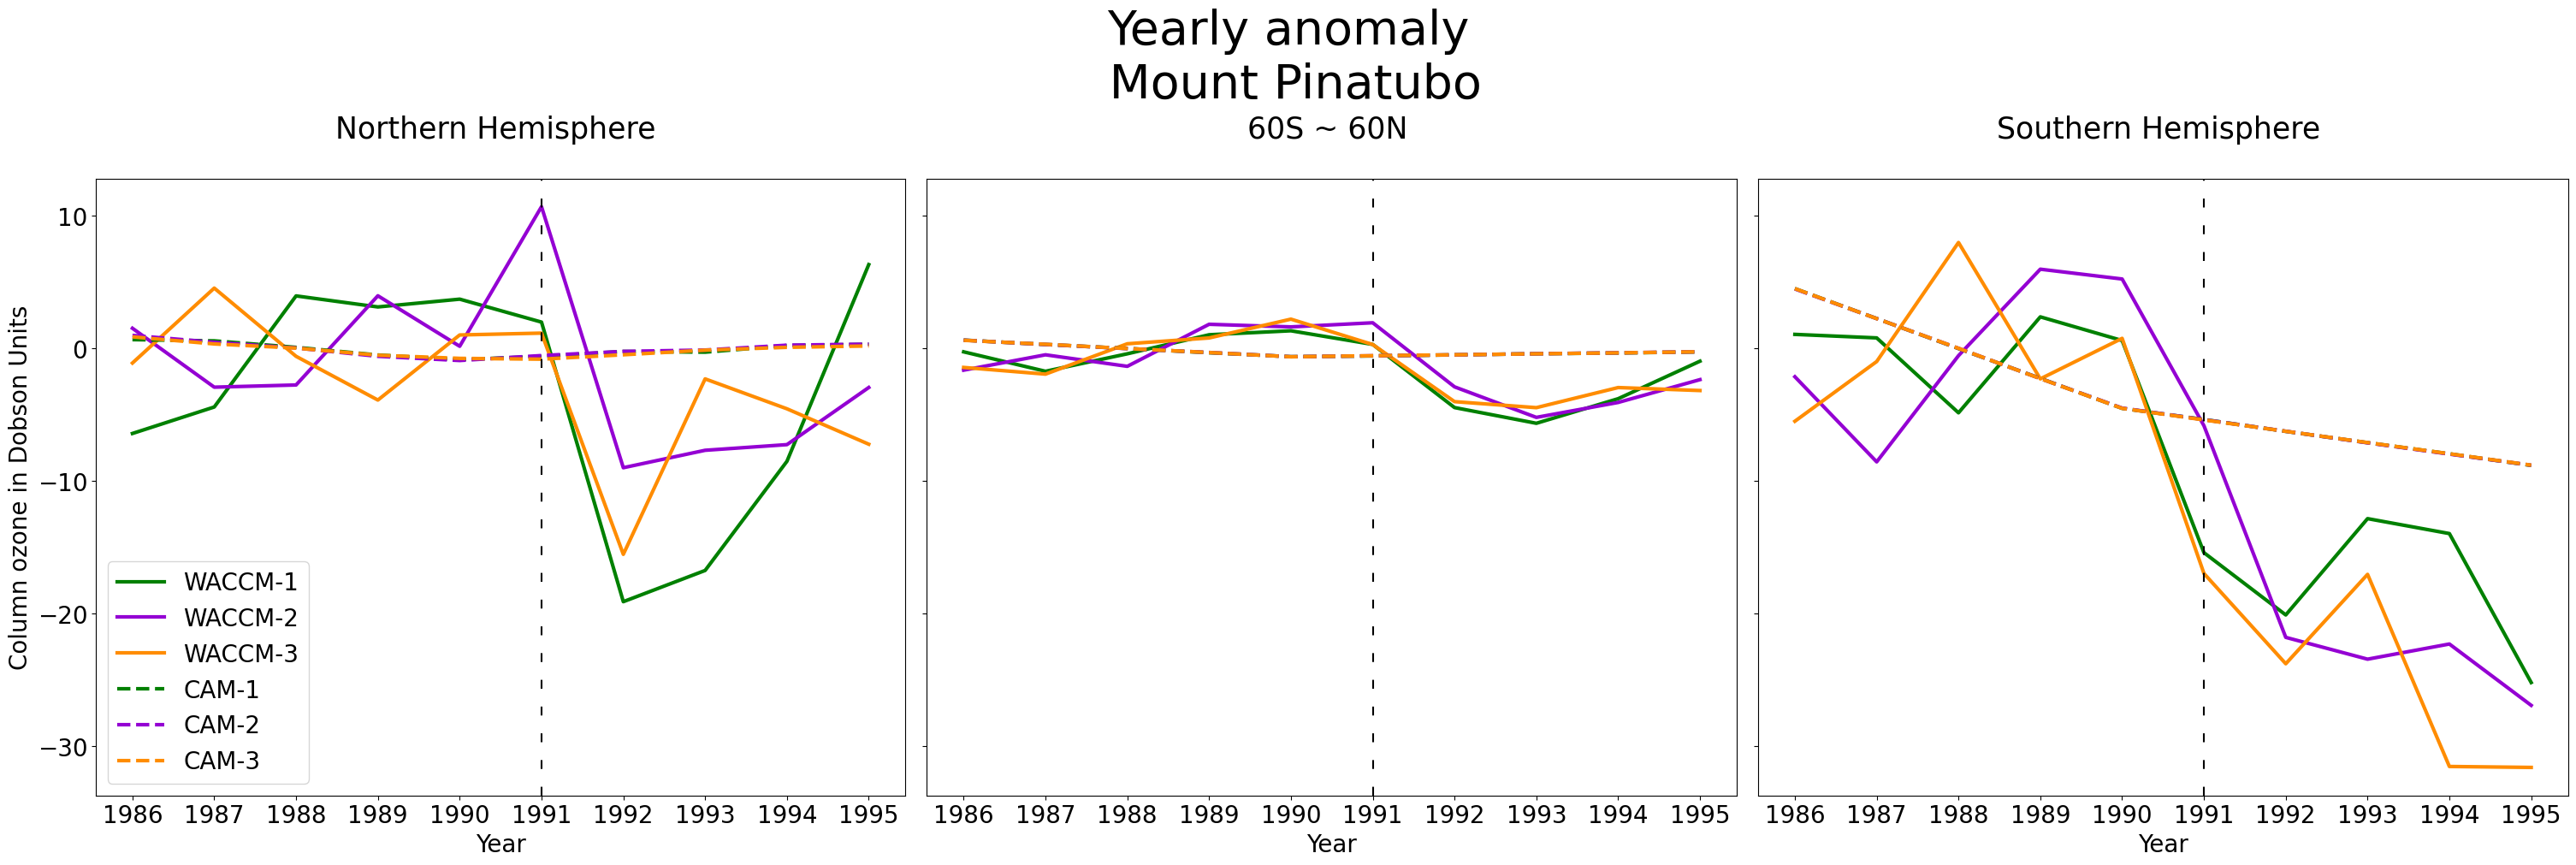

In [34]:
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, constrained_layout=True, sharey=True, figsize=(30,10))


color = ['green','darkviolet','darkorange']

for i in range(3):
    j = i+1
    waccm_pina.year_NH_anom[i].plot(label='WACCM-'+ str(j), ax=axs1, linewidth=3, color=color[i])
    year_waccm_trop_anom_pina_o3[i].plot(label='WACCM-'+ str(j), ax=axs2, linewidth=3, color=color[i])
    waccm_pina.year_SH_anom[i].plot(label='WACCM-'+ str(j), ax=axs3, linewidth=3, color=color[i])

for i in range(3):
    j = i+1    
    cam_pina.year_NH_anom[i].plot(label='CAM-'+ str(j), ax=axs1, linestyle='--', linewidth=3, color=color[i])
    year_cam_trop_anom_pina_o3[i].plot(label='CAM-'+ str(j), ax=axs2, linestyle='--', linewidth=3, color=color[i])
    cam_pina.year_SH_anom[i].plot(label="CAM-"+ str(j), ax=axs3, linestyle='--', linewidth=3, color=color[i])

#for i in range(3):
#    j = i+1
#    year_waccm_trop_anom_pina_o3[i].plot(label='WACCM-'+ str(j), ax=axs2, linewidth=3, color=color[i])
#    year_cam_trop_anom_pina_o3[i].plot(label='CAM-'+ str(j), ax=axs2, linestyle='--', linewidth=3, color=color[i])
#    
#for i in range(3):
#    j = i+1
#    waccm_pina.year_SH_anom[i].plot(label='WACCM-'+ str(j), ax=axs3, linewidth=3, color=color[i])
#    cam_pina.year_SH_anom[i].plot(label="CAM-"+ str(j), ax=axs3, linestyle='--', linewidth=3, color=color[i])

axs1.axvline(1991, color='k',linestyle='--',dashes=(5, 10))
axs2.axvline(1991, color='k',linestyle='--',dashes=(5, 10))
axs3.axvline(1991, color='k',linestyle='--',dashes=(5, 10))

fig.suptitle('Yearly anomaly\n Mount Pinatubo', fontsize=40)

axs1.set_xticks(cam_pina.year_SH_anom.year)
axs2.set_xticks(cam_pina.year_SH_anom.year)
axs3.set_xticks(cam_pina.year_SH_anom.year)

axs1.set_ylabel(year_waccm_trop_anom_pina_o3.long_name, fontsize=20)
axs2.set_ylabel('', fontsize=20)
axs3.set_ylabel('', fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)
axs3.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)
axs3.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)
axs3.tick_params(axis="y", labelsize=20)

axs1.set_title("Northern Hemisphere \n" , fontsize=25)
axs2.set_title("60S ~ 60N \n" , fontsize=25)
axs3.set_title("Southern Hemisphere \n" , fontsize=25)

axs1.legend(fontsize=20)
path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'
plt.savefig(path + 'O3_yearly_anom_pina.png')


